# Price Prediction

a project by Felix Marschall, Mika Scheid, Elias Müller and Jan Dorn

## Notebook Structure

1. **Introduction**: Overview of the project and objectives.
2. **Dataset Overview**: Description of the dataset and its key components.
3. **Data Preparation**: Data consolidation, data cleaning, data transformation, data reduction.
4. **Exploratory Data Analysis**: Insights derived from the dataset, including visualizations.
5. **Feature Engineering**: Selection of important features.
6. **Modeling**: Implementation and comparison of different machine learning models.
7. **Hyperparameter Tuning**: Optimization of model parameters.
8. **Evaluation**: Analysis of model performance using various metrics.
9. **Conclusion**: Summary of findings and future work.


## 0. Installing and importing Dependencies

In [106]:
%pip install pandas
%pip install matplotlib

Python(38724) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


Python(38733) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging

## 1. Introduction

This project aims to predict Airbnb listing prices using a dataset from Inside Airbnb. The focus is on applying data science techniques to preprocess, analyze, and model the data while exploring additional insights such as time-based patterns and geolocation analysis.

## 2. Dataset Overview

For each location (Amsterdam, Barcelona, Berlin, Budapest, Copenhagen, Istanbul, Lisbon, London, Oslo, Paris, Prague, Rome), various datasets are available from [Inside Airbnb](https://insideairbnb.com/get-the-data/). The most relevant ones are:

- **listings.csv.gz**: Detailed listings data
- **calendar.csv.gz**: Detailed calendar data
- **reviews.csv.gz**: Detailed review data

### **Hypothesis 1**: Reviews are not useful for price prediction

We hypothesize that reviews do not contribute to price prediction, as they are influenced by the price itself. Higher-priced Airbnbs may receive lower ratings if expectations are not met, while cheaper ones may be rated higher due to better perceived value.

Since reviews inherently reflect the price and do not provide independent insights into the accommodation's quality or value, we will exclude them from the initial price prediction model. Instead, we will focus on features like location, property type, size, and amenities, which have a direct impact on the price.

All relevant data for this analysis is available in the **listings.csv.gz** file, which we downloaded for each city from [Inside Airbnb](https://insideairbnb.com/get-the-data/).

### **Hypothesis 2**: Prices remain constant throughout the year

One might assume that Airbnb prices change throughout the year depending on demand. However, this is not the case. 

Upon inspecting the **calendar.csv.gz** file for Amsterdam using SQL (due to the large size of the dataset, SQL is more efficient), we found that prices for every listing remain constant over the entire year.

```sql
SELECT listing_id, COUNT(DISTINCT price) AS num_distinct_prices
FROM calendar
GROUP BY listing_id
ORDER BY num_distinct_prices DESC;
```

SQL Output:

<img src="./images/hypothesis_2.png" alt="SQL Output" width="300"/>

As we can see from the output, no listing in the Amsterdam dataset has more than one price for the same listing throughout the given timeframe. We assume this holds true for every listing in every city, so we do not consider price fluctuations over time in this analysis.


## 3. Data Preparation

Consists of Data Consolidation, Data Cleaning, Data Transformation and Data Reduction




### 3.1 Data Consolidation

The Airbnb listing data for each city is located in `./data/<city_name>/listings.csv.gz`. As a first step, we need to consolidate these datasets into a single dataframe for further analysis.

Checking the columns of each dataset reveals the following:

In [108]:
data_dir = './data'

for city in os.listdir(data_dir):
    city_path = os.path.join(data_dir, city)
    listings_path = os.path.join(city_path, 'listings.csv.gz')
    if os.path.isdir(city_path) and os.path.exists(listings_path):
        try:
            df = pd.read_csv(listings_path, compression='gzip', nrows=1)
            print(f"{city}: {df.shape[1]} columns")
            # print(f"Columns: {list(df.columns)}\n")
        except Exception as e:
            print(f"Error reading {listings_path}: {e}")

barcelona: 79 columns
paris: 75 columns
istanbul: 75 columns
lisbon: 79 columns
budapest: 79 columns
oslo: 75 columns
london: 75 columns
prague: 79 columns
berlin: 75 columns
rome: 79 columns
amsterdam: 79 columns
copenhagen: 75 columns
stockholm: 75 columns


The datasets have different numbers of columns. The datasets with 75 columns are missing the following columns:

- availability_eoy
- number_of_reviews_ly
- estimated_occupancy_l365d
- estimated_revenue_l365d

In the consolidating script, the schema is defined to include all 79 columns. The datasets that are missing these 4 columns will have null values for these fields.

In [109]:
# configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

data_dir = './data'
all_dfs = []
success = True

# define the desired schema
schema = [
    "id","listing_url","scrape_id","last_scraped","source","name","description","neighborhood_overview","picture_url",
    "host_id","host_url","host_name","host_since","host_location","host_about","host_response_time","host_response_rate",
    "host_acceptance_rate","host_is_superhost","host_thumbnail_url","host_picture_url","host_neighbourhood",
    "host_listings_count","host_total_listings_count","host_verifications","host_has_profile_pic","host_identity_verified",
    "neighbourhood","neighbourhood_cleansed","neighbourhood_group_cleansed","latitude","longitude","property_type",
    "room_type","accommodates","bathrooms","bathrooms_text","bedrooms","beds","amenities","price","minimum_nights",
    "maximum_nights","minimum_minimum_nights","maximum_minimum_nights","minimum_maximum_nights","maximum_maximum_nights",
    "minimum_nights_avg_ntm","maximum_nights_avg_ntm","calendar_updated","has_availability","availability_30",
    "availability_60","availability_90","availability_365","calendar_last_scraped","number_of_reviews",
    "number_of_reviews_ltm","number_of_reviews_l30d","availability_eoy","number_of_reviews_ly",
    "estimated_occupancy_l365d","estimated_revenue_l365d","first_review","last_review","review_scores_rating",
    "review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication",
    "review_scores_location","review_scores_value","license","instant_bookable","calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes","calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms","reviews_per_month"
]

for city in os.listdir(data_dir):
    city_path = os.path.join(data_dir, city)
    listings_path = os.path.join(city_path, 'listings.csv.gz')
    if os.path.isdir(city_path) and os.path.exists(listings_path):
        try:
            df = pd.read_csv(listings_path, compression='gzip', low_memory=False)
            df = df.reindex(columns=schema)
            all_dfs.append(df)
            logging.info(f"{city}: {df.shape[0]} listings loaded from {listings_path}")
        except Exception as e:
            logging.error(f"Failed to load {listings_path}: {e}")
            success = False
    else:
        logging.warning(f"No listings.csv.gz found in {city_path}")

if all_dfs:
    try:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        output_path = os.path.join(data_dir, 'all_listings_consolidated.csv')
        combined_df.to_csv(output_path, index=False, na_rep='null')
        logging.info(f"Successfully combined all listings with defined schema. Final shape: {combined_df.shape}")
        logging.info(f"Combined CSV saved to {output_path}")

        # validation of csv file
        try:
            test_df = pd.read_csv(output_path, low_memory=False)
            logging.info(f"Validation: Successfully read {output_path}. Shape: {test_df.shape}")
        except Exception as e:
            logging.error(f"Validation failed: Could not read {output_path}: {e}")
            success = False

    except Exception as e:
        logging.error(f"Failed to concatenate or save combined DataFrame: {e}")
        success = False
else:
    logging.error("No dataframes to combine. Exiting.")
    success = False

if success:
    logging.info("Data consolidation completed successfully.")
else:
    logging.error("Data consolidation encountered errors.")

INFO: barcelona: 19422 listings loaded from ./data/barcelona/listings.csv.gz
INFO: paris: 91031 listings loaded from ./data/paris/listings.csv.gz
INFO: istanbul: 29400 listings loaded from ./data/istanbul/listings.csv.gz
INFO: lisbon: 24264 listings loaded from ./data/lisbon/listings.csv.gz
INFO: budapest: 11209 listings loaded from ./data/budapest/listings.csv.gz
INFO: oslo: 10762 listings loaded from ./data/oslo/listings.csv.gz
INFO: london: 95144 listings loaded from ./data/london/listings.csv.gz
INFO: prague: 10108 listings loaded from ./data/prague/listings.csv.gz
INFO: berlin: 13984 listings loaded from ./data/berlin/listings.csv.gz
INFO: rome: 34542 listings loaded from ./data/rome/listings.csv.gz
INFO: amsterdam: 10075 listings loaded from ./data/amsterdam/listings.csv.gz
INFO: copenhagen: 21707 listings loaded from ./data/copenhagen/listings.csv.gz
INFO: stockholm: 5223 listings loaded from ./data/stockholm/listings.csv.gz
INFO: Successfully combined all listings with defined 

In [110]:
combined_df = pd.read_csv("data/all_listings_consolidated.csv")

/var/folders/gw/vypgnpdj4c9831h8cnz67sxr0000gn/T/ipykernel_20529/500600756.py:1: DtypeWarning: Columns (29,72) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv("data/all_listings_consolidated.csv")


In [111]:
combined_df

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,18674,https://www.airbnb.com/rooms/18674,20250305023237,2025-03-06,city scrape,Huge flat for 8 people close to Sagrada Familia,110m2 apartment to rent in Barcelona. Located ...,Apartment in Barcelona located in the heart of...,https://a0.muscache.com/pictures/13031453/413c...,71615,...,4.70,4.80,4.32,HUTB-002062,t,29,29,0,0,0.31
1,23197,https://www.airbnb.com/rooms/23197,20250305023237,2025-03-07,city scrape,"Forum CCIB DeLuxe, Spacious, Large Balcony, relax",Beautiful and Spacious Apartment with Large Te...,"Strategically located in the Parc del Fòrum, a...",https://a0.muscache.com/pictures/miso/Hosting-...,90417,...,4.99,4.63,4.66,HUTB005057,f,1,1,0,0,0.48
2,32711,https://www.airbnb.com/rooms/32711,20250305023237,2025-03-06,city scrape,Sagrada Familia area - Còrsega 1,A lovely two bedroom apartment only 250 m from...,What's nearby <br />This apartment is located...,https://a0.muscache.com/pictures/357b25e4-f414...,135703,...,4.89,4.89,4.49,HUTB-001722,f,3,3,0,0,0.86
3,34241,https://www.airbnb.com/rooms/34241,20250305023237,2025-03-05,city scrape,Stylish Top Floor Apartment - Ramblas Plaza Real,Located in close proximity to Plaza Real and L...,NaN,https://a0.muscache.com/pictures/2437facc-2fe7...,73163,...,4.68,4.73,4.23,Exempt,f,3,3,0,0,0.14
4,34981,https://www.airbnb.com/rooms/34981,20250305023237,2025-03-05,city scrape,VIDRE HOME PLAZA REAL on LAS RAMBLAS,Spacious apartment for large families or group...,"Located in Ciutat Vella in the Gothic Quarter,...",https://a0.muscache.com/pictures/c4d1723c-e479...,73163,...,4.70,4.66,4.43,HUTB-150671,f,3,3,0,0,1.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376866,1321121257587188985,https://www.airbnb.com/rooms/1321121257587188985,20241230011645,2024-12-30,city scrape,Perfekt familjelägenhet,"Cozy and fresh three with two bedrooms, open p...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,23803002,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
376867,1321592072491619841,https://www.airbnb.com/rooms/1321592072491619841,20241230011645,2024-12-30,city scrape,Designlägenhet,"This unique accommodation of 22 sqm, has large...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,425836786,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
376868,1321811206140917325,https://www.airbnb.com/rooms/1321811206140917325,20241230011645,2024-12-30,city scrape,Best south stockholm,Green unique area with the first pedestrian st...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,389733262,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
376869,1321863150641245338,https://www.airbnb.com/rooms/1321863150641245338,20241230011645,2024-12-30,city scrape,Comfort de Luxe Älvsjö,Bring the whole family to this amazing place w...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,6311326,...,NaN,NaN,NaN,NaN,t,1,1,0,0,NaN


In [112]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376871 entries, 0 to 376870
Data columns (total 79 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            376871 non-null  int64  
 1   listing_url                                   376871 non-null  object 
 2   scrape_id                                     376871 non-null  int64  
 3   last_scraped                                  376871 non-null  object 
 4   source                                        376871 non-null  object 
 5   name                                          376871 non-null  object 
 6   description                                   364558 non-null  object 
 7   neighborhood_overview                         175613 non-null  object 
 8   picture_url                                   376859 non-null  object 
 9   host_id                                       37

### 3.2 Data Cleaning

#### 3.2.1 Handle missing values

Columns with over 40% of missing values can be deleted. Too much missing data to be included in the price prediction model. This is part of 3.4 Data reduction but we already know we don't need these values so let's just do it now.

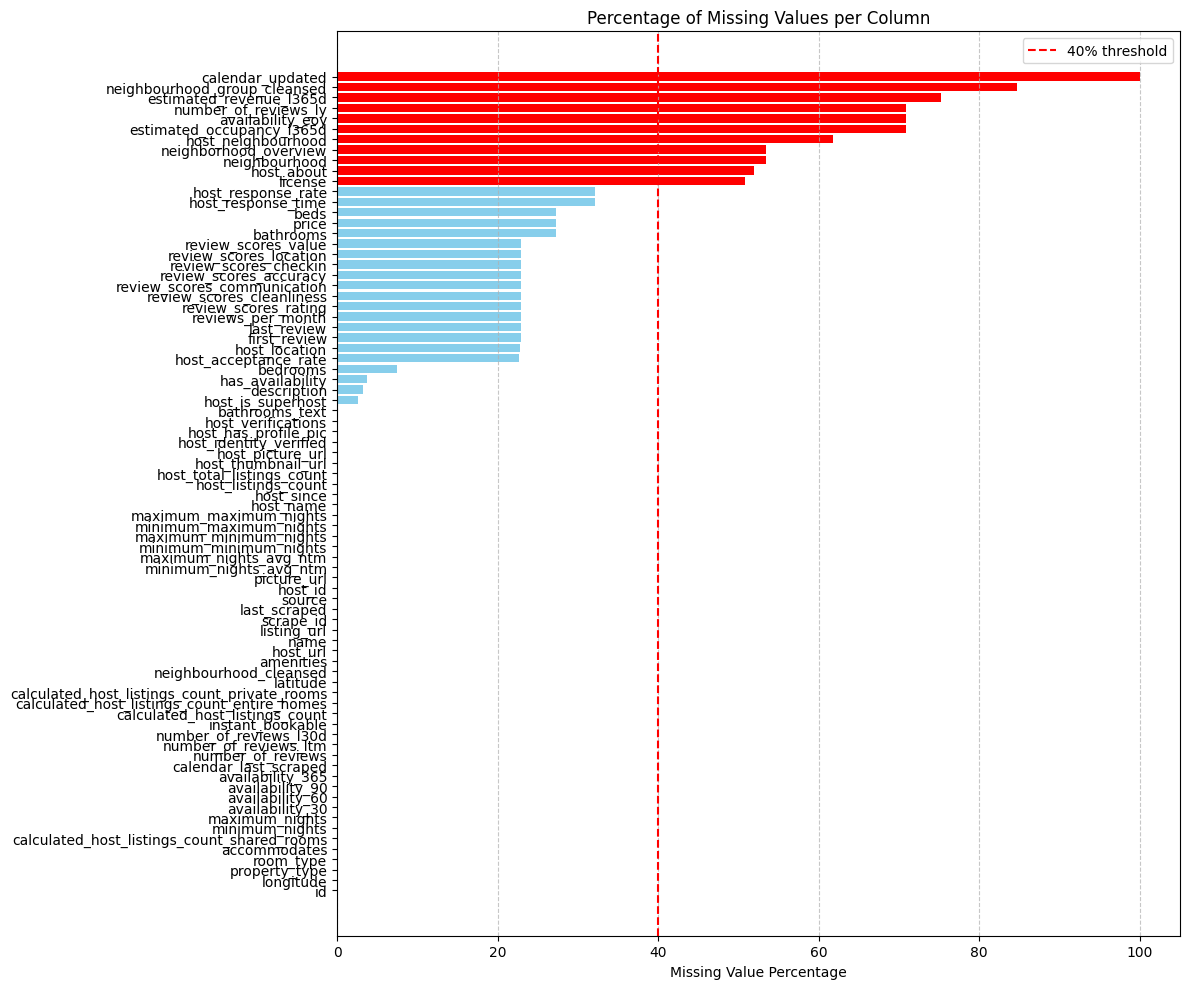

Columns with more than 40% missing values (11 total):
- neighborhood_overview: 53.40%
- host_about: 51.98%
- host_neighbourhood: 61.75%
- neighbourhood: 53.40%
- neighbourhood_group_cleansed: 84.70%
- calendar_updated: 100.00%
- availability_eoy: 70.91%
- number_of_reviews_ly: 70.91%
- estimated_occupancy_l365d: 70.91%
- estimated_revenue_l365d: 75.25%
- license: 50.87%


In [113]:
# number of missing values per column and percentage
missing_counts = combined_df.isnull().sum()
missing_percent = (missing_counts / len(combined_df)) * 100

# combine both in a dataframe for better overview
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percent': missing_percent
})

# sort by percentage for better overview in plot
missing_df_sorted = missing_df.sort_values(by='Missing Percent', ascending=True)

# color the bars red if they have more than 40% missing values
bar_colors = ['red' if val > 40 else 'skyblue' for val in missing_df_sorted['Missing Percent']]

# plot
plt.figure(figsize=(12, 10))
plt.barh(missing_df_sorted.index, missing_df_sorted['Missing Percent'], color=bar_colors)
plt.xlabel('Missing Value Percentage')
plt.title('Percentage of Missing Values per Column')
plt.axvline(x=40, color='red', linestyle='--', linewidth=1.5, label='40% threshold')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# list of columns with more than 40% missing values
columns_to_drop = missing_df[missing_df['Missing Percent'] > 40].index.tolist()

# show
print(f"Columns with more than 40% missing values ({len(columns_to_drop)} total):")
for col in columns_to_drop:
    print(f"- {col}: {missing_df.loc[col, 'Missing Percent']:.2f}%")


Remove these columns:

In [114]:
combined_df_cleaned = combined_df.drop(columns=columns_to_drop)
combined_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376871 entries, 0 to 376870
Data columns (total 68 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            376871 non-null  int64  
 1   listing_url                                   376871 non-null  object 
 2   scrape_id                                     376871 non-null  int64  
 3   last_scraped                                  376871 non-null  object 
 4   source                                        376871 non-null  object 
 5   name                                          376871 non-null  object 
 6   description                                   364558 non-null  object 
 7   picture_url                                   376859 non-null  object 
 8   host_id                                       376871 non-null  int64  
 9   host_url                                      37

Let's inspect the last remaining columns with missing values, their data type and an example.

In [115]:
# missing values
missing_counts = combined_df_cleaned.isnull().sum()
missing_percent = (missing_counts / len(combined_df)) * 100

# filter only columns with missing values
missing_columns = missing_counts[missing_counts > 0].index

# list to store the results
rows = []

for col in missing_columns:
    percent_missing = missing_percent[col]
    dtype = combined_df[col].dtype
    example_values = combined_df[col].dropna().unique()
    example = example_values[0] if len(example_values) > 0 else "—"
    
    rows.append({
        "column": col,
        "missing": round(percent_missing, 2),
        "datatype": dtype,
        "example": example
    })

# create dataframe and sort
missing_table = pd.DataFrame(rows)
missing_table = missing_table.sort_values(by="missing", ascending=False)

# show table
print(missing_table.to_string(index=False))


                     column  missing datatype                                                                                                                                                                                                                        example
         host_response_time    32.13   object                                                                                                                                                                                                                 within an hour
         host_response_rate    32.13   object                                                                                                                                                                                                                            99%
                       beds    27.32  float64                                                                                                                                                    

We'll focus on a few key columns for targeted cleaning. For all other columns, missing values will be filled with the label "ML" (Missing Label).

1. Since we're predicting the **price column**, we'll remove any rows where the price is missing (~27%). Although a trained model could estimate these prices, we can't verify their accuracy — and given the amount of available data, these entries don't add much value for now.
2. **beds**: Median
3. **bathrooms**: Median
4. review_scores_value, review_scores_location, review_scores_checkin, review_scores_communication, review_scores_cleanliness, review_scores_accuracy,review_scores_rating: Median or Mean depending on distribution -> check distribution
5. **bedrooms**: Median
6. rest: "ML" or median depending on data type

In [116]:
# 1. remove rows with missing price
combined_df_cleaned = combined_df_cleaned[combined_df_cleaned['price'].notna()]

# 2. 3. 5.
combined_df_cleaned['beds'] = combined_df_cleaned['beds'].fillna(combined_df_cleaned['beds'].median())
combined_df_cleaned['bathrooms'] = combined_df_cleaned['bathrooms'].fillna(combined_df_cleaned['bathrooms'].median())
combined_df_cleaned['bedrooms'] = combined_df_cleaned['bedrooms'].fillna(combined_df_cleaned['bedrooms'].median())


In [117]:
# 4. check skewness
print("Skewness review_scores_value:", combined_df['review_scores_value'].skew())
print("Skewness review_scores_location:", combined_df['review_scores_location'].skew())
print("Skewness review_scores_checkin:", combined_df['review_scores_checkin'].skew())
print("Skewness review_scores_communication:", combined_df['review_scores_communication'].skew())
print("Skewness review_scores_cleanliness:", combined_df['review_scores_cleanliness'].skew())
print("Skewness review_scores_accuracy:", combined_df['review_scores_accuracy'].skew())
print("Skewness review_scores_rating:", combined_df['review_scores_rating'].skew())



Skewness review_scores_value: -3.6744778325479843
Skewness review_scores_location: -4.579815541328247
Skewness review_scores_checkin: -5.45570245117949
Skewness review_scores_communication: -5.684813640990981
Skewness review_scores_cleanliness: -3.647138718000067
Skewness review_scores_accuracy: -4.73862272201737
Skewness review_scores_rating: -4.205680077165399


The skewness of each each column is |col| > 0.5, so we choose the median.

In [118]:
# 4. fill with median
combined_df_cleaned['review_scores_value'] = combined_df_cleaned['review_scores_value'].fillna(combined_df_cleaned['review_scores_value'].median())
combined_df_cleaned['review_scores_location'] = combined_df_cleaned['review_scores_location'].fillna(combined_df_cleaned['review_scores_location'].median())
combined_df_cleaned['review_scores_checkin'] = combined_df_cleaned['review_scores_checkin'].fillna(combined_df_cleaned['review_scores_checkin'].median())
combined_df_cleaned['review_scores_communication'] = combined_df_cleaned['review_scores_communication'].fillna(combined_df_cleaned['review_scores_communication'].median())
combined_df_cleaned['review_scores_cleanliness'] = combined_df_cleaned['review_scores_cleanliness'].fillna(combined_df_cleaned['review_scores_cleanliness'].median())
combined_df_cleaned['review_scores_accuracy'] = combined_df_cleaned['review_scores_accuracy'].fillna(combined_df_cleaned['review_scores_accuracy'].median())


In [119]:
# 6. rest: "ML" or median
combined_df_cleaned = combined_df_cleaned.copy()

for col in combined_df_cleaned.columns:
    if pd.api.types.is_numeric_dtype(combined_df_cleaned[col]):
        median_value = combined_df_cleaned[col].median()
        combined_df_cleaned[col] = combined_df_cleaned[col].fillna(median_value)
    else:
        combined_df_cleaned[col] = combined_df_cleaned[col].fillna("ML")

# Prüfung
combined_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 274274 entries, 0 to 376870
Data columns (total 68 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            274274 non-null  int64  
 1   listing_url                                   274274 non-null  object 
 2   scrape_id                                     274274 non-null  int64  
 3   last_scraped                                  274274 non-null  object 
 4   source                                        274274 non-null  object 
 5   name                                          274274 non-null  object 
 6   description                                   274274 non-null  object 
 7   picture_url                                   274274 non-null  object 
 8   host_id                                       274274 non-null  int64  
 9   host_url                                      274274 

#### 3.2.2 Reduce noise

First, identify the outliers. Only applicable on numerical columns. No interpretation of id columns possible.

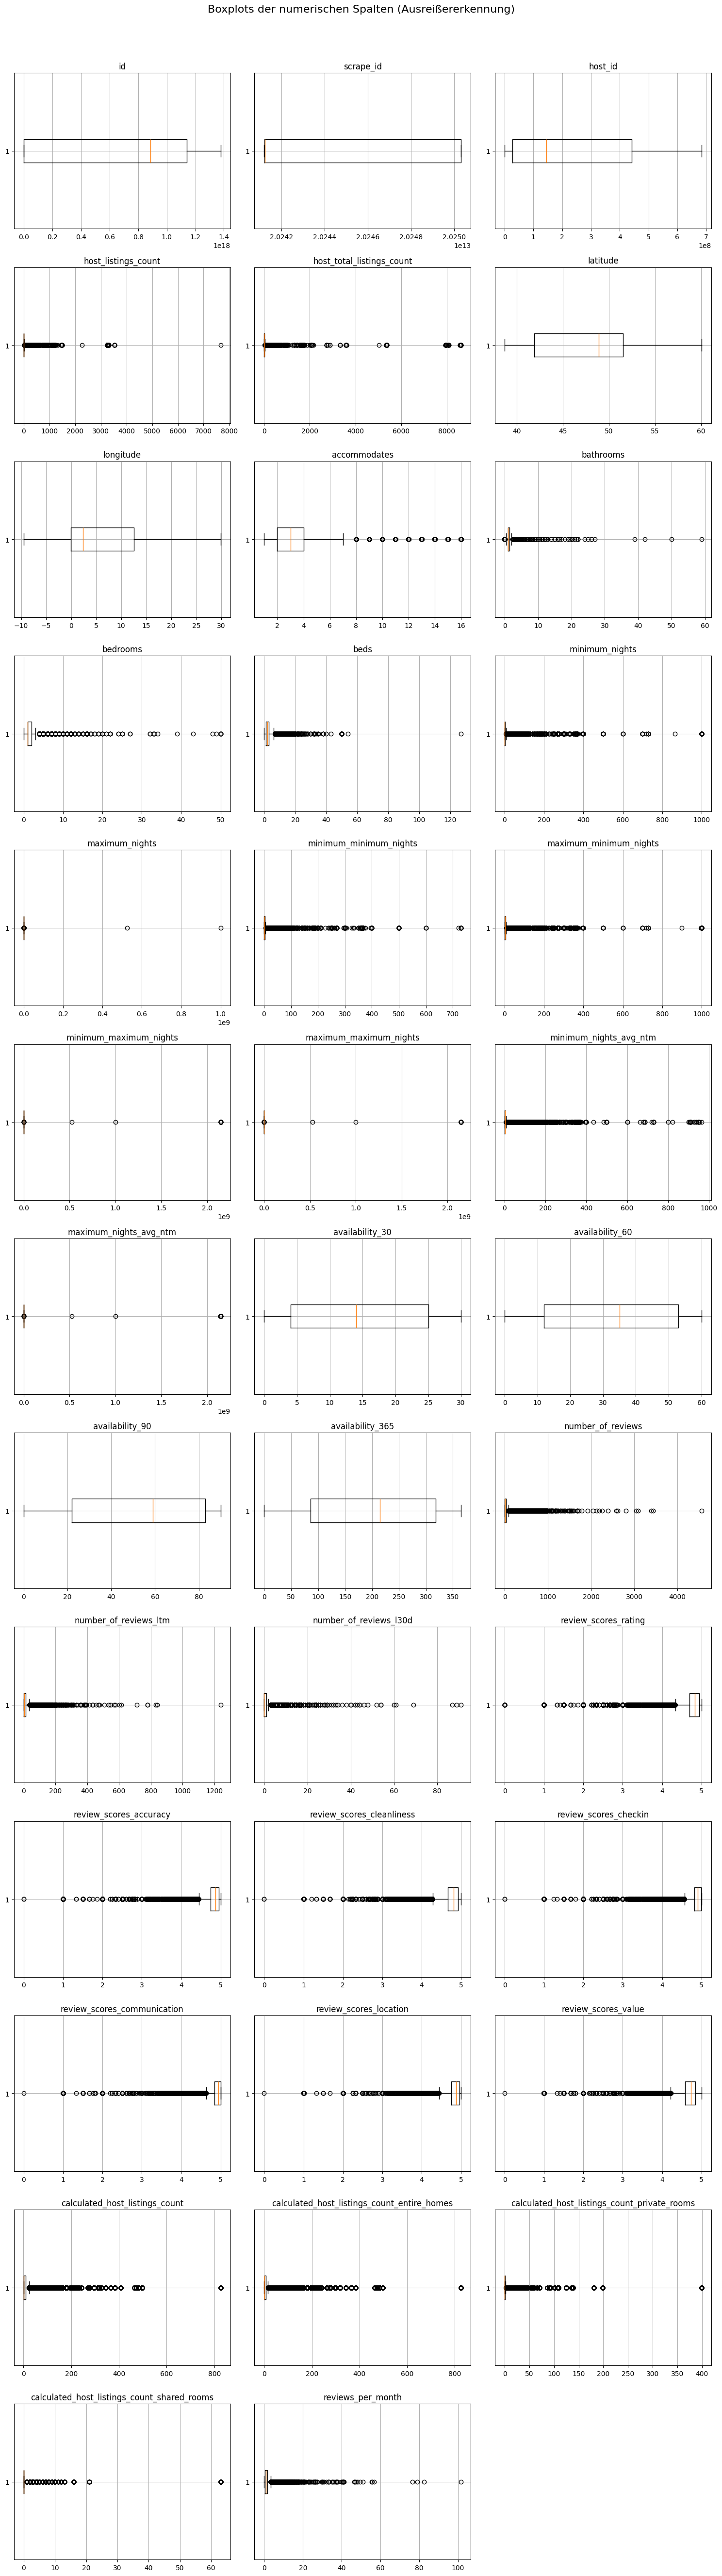

In [120]:
# extract numerical columns
numeric_cols = combined_df_cleaned.select_dtypes(include=['number']).columns.tolist()

# prepare number of subplots
num_cols = len(numeric_cols)
cols_per_row = 3
num_rows = (num_cols + cols_per_row - 1) // cols_per_row

# create boxplots
fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(cols_per_row * 5, num_rows * 4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].boxplot(combined_df_cleaned[col].dropna(), vert=False)
    axes[i].set_title(col)
    axes[i].grid(True)

# remove empty axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Boxplots der numerischen Spalten (Ausreißererkennung)", fontsize=16, y=1.02)
plt.show()


There are obvious outliers in the columns maximum_nights, minimum_maximum_nights, maximum_maximum_nights and maximum_nights_avg_ntm. We suspect these columns won't be needed in the price prediction models, so we proceed to the data transformation.

### Data Transformation

Now we transform the data into a format that is more suitable for modeling. This includes normalizing columns, adjusting data types if needed, discretizing values, and even creating new features.

In [121]:
combined_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 274274 entries, 0 to 376870
Data columns (total 68 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            274274 non-null  int64  
 1   listing_url                                   274274 non-null  object 
 2   scrape_id                                     274274 non-null  int64  
 3   last_scraped                                  274274 non-null  object 
 4   source                                        274274 non-null  object 
 5   name                                          274274 non-null  object 
 6   description                                   274274 non-null  object 
 7   picture_url                                   274274 non-null  object 
 8   host_id                                       274274 non-null  int64  
 9   host_url                                      274274 

We have identified the need for the following transformations (without normalization):
1. **host_since**, **first_review**, **last_review** needs to be a datetime datatype
2. **host_location** can be divided in city and country
3. **price** needs to be a numerical value -> remove the dollar sign
4. **host_response_rate** and **host_acceptance_rate** should be a numerical value
5. **host_response_time** can be transformed into a numerical representation: within an hour -> 1; within a few hours -> 2; ...

In some of these transformations, we need to set the previously set "ML" values to the median.

In [122]:
df_transformed = combined_df_cleaned.copy()

# 1. transform date columns to datetime and replace NaT with median
date_cols = ['host_since', 'first_review', 'last_review']
for col in date_cols:
    # convert to datetime
    df_transformed[col] = pd.to_datetime(df_transformed[col], errors='coerce')
    # calculate median
    median_date = df_transformed[col].median()
    # replace NaT with median
    df_transformed[col] = df_transformed[col].fillna(median_date)

# 2. split host_location into host_city and host_country
def split_location(val):
    if isinstance(val, str) and ',' in val:
        parts = val.split(',')
        city = parts[0].strip()
        country = parts[-1].strip()
        return city, country
    else:
        return "ML", "ML"

df_transformed[['host_city', 'host_country']] = df_transformed['host_location'].apply(
    lambda x: pd.Series(split_location(x))
)

# 3. price: remove $-sign and commas, then convert to float
df_transformed['price'] = (
    df_transformed['price']
    .astype(str)
    .str.replace(r"[\$,]", "", regex=True)
    .astype(float)
)

# 4. host_response_rate and host_acceptance_rate: remove % sign, convert to float and replace "ML" with median
for col in ['host_response_rate', 'host_acceptance_rate']:
    # replace % sign and convert to float
    col_series = df_transformed[col].astype(str).str.replace('%', '', regex=True)
    # calculate median
    valid_values = col_series[col_series != 'ML'].astype(float)
    median_val = valid_values.median()
    # replace "ML" with median and convert to float
    df_transformed[col] = col_series.replace('ML', str(median_val)).astype(float)

# 5. host_response_time: transform into numerical representation
df_transformed['host_response_time_num'] = df_transformed['host_response_time'].map({
    'within an hour': 1,
    'within a few hours': 2,
    'within a day': 3,
    'a few days or more': 4,
    'ML': '5'
}).astype(float)

# check result
print("host_since, first_review, last_review: \n", df_transformed[['host_since', 'first_review', 'last_review']].dtypes)
print("host_city, host_country: \n", df_transformed[['host_city', 'host_country']].head())
print("price: \n", df_transformed['price'].head())
print("host_response_rate, host_acceptance_rate: \n", df_transformed[['host_response_rate', 'host_acceptance_rate']].head())
print("host_response_time_num: \n", df_transformed['host_response_time_num'].head())


host_since, first_review, last_review: 
 host_since      datetime64[ns]
first_review    datetime64[ns]
last_review     datetime64[ns]
dtype: object
host_city, host_country: 
    host_city host_country
0  Barcelona        Spain
1  Catalonia        Spain
2  Barcelona        Spain
3  Barcelona        Spain
4  Barcelona        Spain
price: 
 0    179.0
1    251.0
2    104.0
3    157.0
4    401.0
Name: price, dtype: float64
host_response_rate, host_acceptance_rate: 
    host_response_rate  host_acceptance_rate
0                99.0                  91.0
1               100.0                  95.0
2               100.0                 100.0
3               100.0                  97.0
4               100.0                  97.0
host_response_time_num: 
 0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: host_response_time_num, dtype: float64


In [123]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 274274 entries, 0 to 376870
Data columns (total 71 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   id                                            274274 non-null  int64         
 1   listing_url                                   274274 non-null  object        
 2   scrape_id                                     274274 non-null  int64         
 3   last_scraped                                  274274 non-null  object        
 4   source                                        274274 non-null  object        
 5   name                                          274274 non-null  object        
 6   description                                   274274 non-null  object        
 7   picture_url                                   274274 non-null  object        
 8   host_id                                       274274 non-nu